<a href="https://colab.research.google.com/github/aldencabajar/PublicInfrastructurePH/blob/master/m5_nn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib
import matplotlib.pyplot as plt
calendar = pd.read_csv("drive/My Drive/calendar.csv")
sales = pd.read_csv("drive/My Drive/sales_train_evaluation.csv")
print("calendar shape:" , calendar.shape, "\nsales shape:", sales.shape)

calendar shape: (1969, 14) 
sales shape: (30490, 1947)


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [3]:
reduce_mem_usage(calendar)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%


In [4]:
from tqdm import tqdm
days_col = sales.columns[sales.columns.str.contains(r'd_\d*')] 
def ts_agg(df, grp, i):
    if 'X' in grp and 'Total' not in grp:
        agg_col = grp[np.where(np.array(grp) != 'X')[0][0]]
        fn = df[np.append(agg_col, days_col)].set_index(agg_col).groupby(agg_col).apply(sum).reset_index()
        fn['id2'] = 'X'
        fn['id'] = fn[np.array([agg_col, 'id2'])].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop([agg_col, 'id2'], inplace = True, axis = 1)
        
    elif 'Total' in grp:
        df['id'] = 'Total_X'
        fn = df[np.append('id', days_col)].set_index('id').groupby('id').apply(sum).reset_index()
        
        
    else:
        fn = df[np.append(grp, days_col)].set_index(grp).groupby(grp).apply(sum).reset_index()
        fn['id'] = fn[grp].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop(grp, inplace = True, axis = 1)
    
    fn['lvl'] = i 
        
    return(fn)
### DETERMINE AGGREGATED SALES ####
levels = (['Total','X'], ['state_id', 'X'], ['store_id', 'X'], ['cat_id', 'X'], ['dept_id', 'X'], 
          ['state_id', 'cat_id'], ['state_id', 'dept_id'], ['store_id', 'cat_id'], ['store_id', 'dept_id'], 
          ['item_id', 'X'], ['state_id', 'item_id'], ['item_id', 'store_id'])

agg_sales_list = []
for i, lv in tqdm(enumerate(levels)):
    agg_sales_list.append(ts_agg(sales, lv, i + 1))


12it [00:35,  2.95s/it]


In [5]:
agg_sales_all = pd.concat(agg_sales_list)
agg_sales_all.reset_index(drop = True, inplace = True)

# change NaNs to String: None
id_vars = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id']

for id_ in id_vars:
  agg_sales_all.loc[agg_sales_all[id_].isna(), id_] =  "none"

for i in ['store_id', 'item_id']:
      for j in ['CA', 'WI', 'TX']:
          agg_sales_all.loc[agg_sales_all[i].str.contains(j), 'state_id'] = j 


agg_sales_all.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,...,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,lvl,state_id,id2,store_id,cat_id,dept_id,item_id
0,Total_X,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,23071,23658,23756,26445,34833,36380,21804,24070,21443,20318,23721,31689,29283,23966,20501,20757,20277,22529,29908,28707,21240,22872,22046,23475,23572,31202,34876,24562,22752,...,35343,35033,40517,48962,49795,38793,35487,34445,34732,42896,50429,53032,43181,44314,39601,40763,43805,54239,45609,46400,39379,42248,40503,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338,1,none,NaN,none,none,none,none
1,CA_X,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,10933,10350,11204,11354,14610,15630,9044,9496,8844,7835,10025,13870,13465,11997,9130,8941,8514,9847,13652,12491,9196,9782,9537,9710,10444,13784,16057,10953,10299,...,15148,14488,17095,21834,23187,17524,15012,14836,14664,17180,22327,23689,19117,17830,17266,16197,17638,23119,19960,18916,16971,16191,15498,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644,2,CA,X,none,none,none,none
2,TX_X,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,6224,6740,6109,7202,10081,11725,6719,7460,6606,6412,6711,9150,9789,7297,6628,5814,6175,6286,8586,9086,6555,7082,6145,6639,6584,9238,10423,7623,6335,...,9600,9602,10615,12266,12282,10662,9933,9575,9655,12162,12694,14193,10719,11949,9909,10833,11773,13668,11385,12035,10580,11314,11491,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815,2,TX,X,none,none,none,none
3,WI_X,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,5914,6568,6443,7889,10142,9025,6041,7114,5993,6071,6985,8669,6029,4672,4743,6002,5588,6396,7670,7130,5489,6008,6364,7126,6544,8180,8396,5986,6118,...,10595,10943,12807,14862,14326,10607,10542,10034,10413,13554,15408,15150,13345,14535,12426,13733,14394,17452,14264,15449,11828,14743,13514,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879,2,WI,X,none,none,none,none
4,CA_1_X,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078,4316,4354,2757,2430,2272,2009,3015,4553,3966,3264,2441,2377,2414,2701,3719,3548,2246,2549,2559,2568,2978,4096,4832,3138,2997,...,3722,3709,4387,5577,6113,4472,3703,3715,3618,4573,5898,6397,4794,4594,4234,3918,4804,6069,5212,4859,4104,3982,4049,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289,3,CA,X,CA_1,none,none,none


In [6]:
agg_sales_all['wt'] = agg_sales_all.loc[:,days_col] \
.apply(lambda x: np.abs(x- x.shift(1)).mean(), axis = 1)
agg_sales_all['wt']

0        4278.666495
1        1969.115979
2        1348.466495
3        1439.687113
4         651.286598
            ...     
42835       0.388144
42836       0.197938
42837       0.152577
42838       0.064948
42839       0.226804
Name: wt, Length: 42840, dtype: float64

Add dummy sales columns (from day 1942 to 1969) to facilitate creation of evaluation days features 

In [7]:
d_cols_eval = ['d_' + str(i) for i in range(1942, 1970)] 
for d in d_cols_eval:
  agg_sales_all[d] = np.nan 

Mapping unique values from each id variable 

In [8]:
agg_sales_all[id_vars]= agg_sales_all[id_vars].apply(lambda x: x.astype('category').cat.codes)
for ids_ in id_vars:
  print(agg_sales_all[ids_].unique())


[3 0 1 2]
[10  0  1  2  3  4  5  6  7  8  9]
[3 0 1 2]
[7 0 1 2 3 4 5 6]
[3049    0    1 ... 3046 3047 3048]


In [9]:
from datetime import datetime
import gc
def create_dataset(start_day, lags):
  days_col = agg_sales_all.columns[
  agg_sales_all.columns.str.contains(r'd_\d*')]

  # determine the minimum day when sales was non-zero  
  agg_sales_all['min_day_sales'] = agg_sales_all.loc[:,days_col] \
  .apply(lambda x: np.min(np.where(x > 0)[0] + 1), axis = 1)

  print("melting the dataset...")
  id_vars = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id']
  agg_melt = pd.melt(agg_sales_all.loc[:,list(days_col) + ['id', 'min_day_sales', 'wt'] + id_vars], 
                   var_name = "day", value_name = "sales", 
                   id_vars = ['id', 'min_day_sales', 'wt'] + id_vars)

  start_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
  agg_melt['day'] = agg_melt['day'].str.replace('d_', '').astype(np.int16)
  agg_melt['min_day_sales'] = agg_melt['min_day_sales'].astype(np.int16)
  agg_melt['sales'] = agg_melt['sales'].astype(np.float32)
  agg_melt['wt'] = agg_melt['wt'].astype(np.float32)
  end_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(end_mem))

  agg_melt.sort_values(by = ["id", "day"], inplace = True)
  agg_melt.reset_index(inplace = True, drop = True)

  print( 'maximum weight:', np.nanmax(agg_melt['wt']), '\nminimum weight:', 
        np.nanmin(agg_melt['wt']))

  agg_melt = agg_melt.loc[
    (agg_melt.min_day_sales <= agg_melt.day) & (agg_melt.day >= start_day)]
  
  agg_melt['scaled'] = agg_melt['sales'] / agg_melt['wt']
  
  # create lagged variables
  print('creating lagged variables...')
  if np.any(np.array(lags) < 28):
    return(print("please pick a lagged variable greater than 28 days")) 
  else:
    for lag in lags:
      lag_name = "lag" + str(lag)
      agg_melt[lag_name] = agg_melt.groupby("id")['scaled'].shift(lag)
    # drop lagged variables with null values 
    lag_vars = agg_melt.columns[agg_melt.columns.str.contains('lag')]
    agg_melt = agg_melt.dropna(subset = lag_vars)

  # remmove unnecessary vars
  print('removing unnecessary variables...')
  agg_melt.drop(columns = ['min_day_sales'], inplace = True)
  gc.collect()


  # prepare calendar variables
  print('preparing calendar variables...')
  calendar = pd.read_csv("drive/My Drive/calendar.csv")
  reduce_mem_usage(calendar)
  calendar['date1'] = calendar.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
  calendar['start_date_year'] = calendar.year.apply(lambda x: datetime.strptime(str(x) + '-01-01', '%Y-%m-%d'))
  calendar['day_of_year'] = calendar['date1'] - calendar['start_date_year']
  calendar['day_of_year'] = calendar['day_of_year'].apply(lambda x: x.days + 1).astype(np.int16)
  calendar['d'] = calendar['d'].str.replace("d_", "").astype(np.int16)
  calendar['year'] -= 2013
  calendar['wday'] -= 1 
  calendar['month'] -= 1 


  from sklearn.preprocessing import StandardScaler 
  scaler = StandardScaler()
  day_of_year = np.arange(1, 366).reshape((-1, 1)) 
  scaler.fit(day_of_year)
  calendar['day_of_year_s'] = scaler.transform(calendar.day_of_year.values.reshape(-1, 1))
  var_list = ['wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'day_of_year_s']

 
 # convert events to integers, can be thought of as ordinal encoding, although 
 # this might not be a good way to represent it 
  event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
  for col in event_cols:
    calendar.loc[calendar[col].isna(),col] =  'none'

  calendar[event_cols] = calendar[event_cols].apply(lambda x: x.astype("category").cat.codes)

  print('merging with sales...')
  sales_calendar_merge = pd.merge(calendar[var_list], 
                                  agg_melt, right_on = "day", 
                                  left_on = "d", how = "right") \
                                  .sort_values(by =['id', 'day'], ignore_index  = True)
  sales_calendar_merge.drop(columns = ['d'], inplace=True)                                
  del agg_melt; gc.collect()
  print('dataset shape:', sales_calendar_merge.shape)


  return(sales_calendar_merge)



In [10]:
dataset = create_dataset(start_day=1000, lags=[28, 35, 42, 49, 56, 63])


melting the dataset...
Memory usage of dataframe is 3700.44 MB
Memory usage of dataframe is 2091.55 MB
maximum weight: 4278.6665 
minimum weight: 0.010309278
creating lagged variables...
removing unnecessary variables...
preparing calendar variables...
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%
merging with sales...
dataset shape: (37213892, 27)


For each input to embed, get the number of unique values and store it in a dict.

In [11]:
emb_cols =['wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI','state_id', 'store_id', 
       'cat_id', 'dept_id', 'item_id']
unq_vals = {col: [] for col in emb_cols}       
for col in emb_cols:
  unq_vals[col] = len(dataset[col].unique())
unq_vals



{'cat_id': 4,
 'dept_id': 8,
 'event_name_1': 31,
 'event_name_2': 3,
 'event_type_1': 5,
 'event_type_2': 3,
 'item_id': 3050,
 'month': 12,
 'snap_CA': 2,
 'snap_TX': 2,
 'snap_WI': 2,
 'state_id': 4,
 'store_id': 11,
 'wday': 7,
 'year': 4}

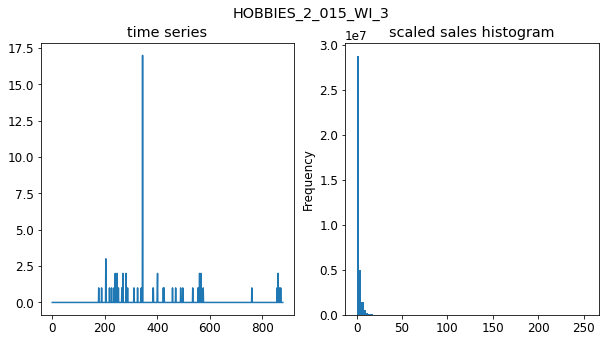

In [12]:
matplotlib.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5))

dataset[dataset.id == 'HOBBIES_2_015_WI_3']['sales'] \
.reset_index(drop = True).plot(kind = 'line', ax = ax1, 
                               title = "time series")
dataset['scaled'].plot(kind = 'hist', bins = 100, ax = ax2, 
                       title = "scaled sales histogram")
plt.suptitle("HOBBIES_2_015_WI_3")                       
plt.show()

In [13]:
print("max. scaled sales:", np.max(dataset['scaled']), 
      "\nmin scaled sales:", np.min(dataset['scaled']))

max. scaled sales: 253.69232177734375 
min scaled sales: 0.0


We now prepare the input data that we will be using for the train, test and validation

In [14]:
train_data = dataset[dataset.day <= 1913]
train_data = train_data[np.isfinite(train_data.wt)]
validation_data = dataset[np.logical_and(dataset.day <= 1941, dataset.day > 1913)]
evaluation_data = dataset[np.logical_and(dataset.day > 1941, dataset.day <= 1969)]



In [15]:
print('train max day:', np.max(train_data['day']),
    '\nvalidation max day:', np.max(validation_data['day']),
    '\nevaluation max day:', np.max(evaluation_data['day']))



train max day: 1913 
validation max day: 1941 
evaluation max day: 1969


In [16]:
print('train data shape:', train_data.shape,
      '\nvalidation data shape:', validation_data.shape,
      '\nevaluation data shape:', evaluation_data.shape)


train data shape: (34814852, 27) 
validation data shape: (1199520, 27) 
evaluation data shape: (1199520, 27)


In [17]:
evaluation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year_s,id,wt,state_id,store_id,cat_id,dept_id,item_id,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63
879,2,4,3,30,4,4,2,0,0,0,-0.370138,CA_1_FOODS,465.540192,0,0,0,7,3049,1942,NaN,NaN,6.214286,6.199250,6.177770,7.030542,5.327145,5.941485
880,3,4,3,30,4,4,2,0,0,0,-0.360648,CA_1_FOODS,465.540192,0,0,0,7,3049,1943,NaN,NaN,5.408771,5.344329,5.095156,5.823342,5.329293,5.580614
881,4,4,3,30,4,4,2,0,0,0,-0.351157,CA_1_FOODS,465.540192,0,0,0,7,3049,1944,NaN,NaN,5.299220,5.348625,5.028567,5.795418,4.586070,5.486100
882,5,4,3,30,4,4,2,0,0,0,-0.341666,CA_1_FOODS,465.540192,0,0,0,7,3049,1945,NaN,NaN,5.254111,5.440991,5.200410,5.262703,5.694460,5.758901
883,6,4,3,30,4,4,2,0,0,0,-0.332175,CA_1_FOODS,465.540192,0,0,0,7,3049,1946,NaN,NaN,6.512864,6.358205,5.812603,6.747001,6.727668,7.348453


In [18]:
validation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year_s,id,wt,state_id,store_id,cat_id,dept_id,item_id,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63
851,2,3,3,30,4,4,2,0,0,0,-0.635879,CA_1_FOODS,465.540192,0,0,0,7,3049,1914,2893.0,6.214286,5.327145,5.941485,5.960817,6.394722,5.294924,5.297072
852,3,3,3,30,4,4,2,0,0,0,-0.626388,CA_1_FOODS,465.540192,0,0,0,7,3049,1915,2518.0,5.408771,5.329293,5.580614,4.732137,5.773938,5.163894,5.168190
853,4,3,3,30,4,4,2,0,0,0,-0.616897,CA_1_FOODS,465.540192,0,0,0,7,3049,1916,2467.0,5.299220,4.586070,5.486100,5.073676,5.355069,5.230483,4.459336
854,5,3,3,30,4,4,2,0,0,0,-0.607406,CA_1_FOODS,465.540192,0,0,0,7,3049,1917,2446.0,5.254111,5.694460,5.758901,4.749321,5.393734,5.294924,4.674140
855,6,3,3,30,4,4,2,0,0,0,-0.597916,CA_1_FOODS,465.540192,0,0,0,7,3049,1918,3032.0,6.512864,6.727668,7.348453,5.904968,6.089700,6.089700,5.827639


prepare one-hot encoding indices for `id` values:  

In [19]:
"""
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

def one_hot_fn(id_arr, ret_vocab = False):
  unique_ids = id_arr.unique()
  len_unique_ids = id_arr.value_counts().set_axis(unique_ids).values 
  stri_split = tf.strings.split(unique_ids, sep = "_")
  vocab, idx = tf.unique(stri_split.flat_values)
  encoded_ids = [one_hot(d, tf.size(vocab).numpy()) for d in unique_ids]
  max_length = np.max([len(i) for i in encoded_ids])
  padded_encoded = np.array(pad_sequences(encoded_ids, maxlen=max_length, padding='post'))
  padded_encoded = np.repeat(padded_encoded, len_unique_ids, axis = 0)

  if ret_vocab:
    return padded_encoded, vocab 
  else:
    return padded_encoded

train_id_enc, vocab = one_hot_fn(train_data['id'], ret_vocab = True)
validation_id_enc = one_hot_fn(validation_data['id'])
eval_id_enc = one_hot_fn(evaluation_data['id'])
print(train_id_enc.shape, validation_id_enc.shape, eval_id_enc.shape)
"""

'\nimport tensorflow as tf\nfrom tensorflow.keras.preprocessing.text import one_hot\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences\n\ndef one_hot_fn(id_arr, ret_vocab = False):\n  unique_ids = id_arr.unique()\n  len_unique_ids = id_arr.value_counts().set_axis(unique_ids).values \n  stri_split = tf.strings.split(unique_ids, sep = "_")\n  vocab, idx = tf.unique(stri_split.flat_values)\n  encoded_ids = [one_hot(d, tf.size(vocab).numpy()) for d in unique_ids]\n  max_length = np.max([len(i) for i in encoded_ids])\n  padded_encoded = np.array(pad_sequences(encoded_ids, maxlen=max_length, padding=\'post\'))\n  padded_encoded = np.repeat(padded_encoded, len_unique_ids, axis = 0)\n\n  if ret_vocab:\n    return padded_encoded, vocab \n  else:\n    return padded_encoded\n\ntrain_id_enc, vocab = one_hot_fn(train_data[\'id\'], ret_vocab = True)\nvalidation_id_enc = one_hot_fn(validation_data[\'id\'])\neval_id_enc = one_hot_fn(evaluation_data[\'id\'])\nprint(train_id_enc.shape, v

### Setting up neural network architecture

For this model, let us try a multi-layer perceptron with *n* hidden layers as a baseline. This is unique since we also try to incorporate an embedding layer (to represent the different ids as a dense vector) along the modelling process. 

In [20]:
unq_vals

{'cat_id': 4,
 'dept_id': 8,
 'event_name_1': 31,
 'event_name_2': 3,
 'event_type_1': 5,
 'event_type_2': 3,
 'item_id': 3050,
 'month': 12,
 'snap_CA': 2,
 'snap_TX': 2,
 'snap_WI': 2,
 'state_id': 4,
 'store_id': 11,
 'wday': 7,
 'year': 4}

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return keras.backend.mean(v)


num_feats = ['lag' + str(i) for i in  [28, 35, 42, 49, 56, 63]]
def create_model(n_hidden_layers, hidden_units, lr):
  
  # input layers
  num_input = layers.Input(shape = (len(num_feats),) , dtype = 'float32', 
                              name = 'ts_features')
  state = layers.Input((1, ), dtype ='int32', name = "state_id")
  store = layers.Input((1, ), dtype ='int32', name = "store_id")
  cat = layers.Input((1, ), dtype ='int32', name = "cat_id")
  dept = layers.Input((1, ), dtype ='int32', name = "dept_id")
  item = layers.Input((1, ), dtype ='int32', name = "item_id")
  wday = layers.Input((1, ), dtype ='int32', name = "wday")
  month = layers.Input((1, ), dtype ='int32', name = "month")
  yr = layers.Input((1, ), dtype ='int32', name = "year")
  ev1 = layers.Input((1, ), dtype ='int32', name = "event_name_1")
  evt1 = layers.Input((1, ), dtype ='int32', name = "event_type_1")
  wi = layers.Input((1, ), dtype ='int32', name = "snap_WI")
  ca = layers.Input((1, ), dtype ='int32', name = "snap_CA")
  tx = layers.Input((1, ), dtype ='int32', name = "snap_TX")

  inp = [state, store, cat, dept, item, wday, month, yr, ev1, evt1, 
          wi, ca, tx, num_input] 

  # embedding layers
  state_emb = layers.Embedding(unq_vals['state_id'], unq_vals['state_id'])(state)
  store_emb = layers.Embedding(unq_vals['store_id'], unq_vals['store_id'])(store)
  cat_emb = layers.Embedding(unq_vals['cat_id'], unq_vals['cat_id'])(cat)
  dept_emb = layers.Embedding(unq_vals['dept_id'], unq_vals['dept_id'])(dept)
  item_emb = layers.Embedding(unq_vals['item_id'], 10)(item)
  wday_emb = layers.Embedding(unq_vals['wday'], unq_vals['wday'])(wday)
  month_emb = layers.Embedding(unq_vals['month'], unq_vals['month'])(month)
  yr_emb = layers.Embedding(unq_vals['year'], unq_vals['month'])(yr)
  ev1_emb = layers.Embedding(unq_vals['event_name_1'], unq_vals['event_name_1'])(ev1)
  evt1_emb = layers.Embedding(unq_vals['event_type_1'], unq_vals['event_type_1'])(evt1)
  wi_emb = layers.Embedding(unq_vals['snap_WI'], unq_vals['snap_WI'])(wi)
  ca_emb = layers.Embedding(unq_vals['snap_CA'], unq_vals['snap_CA'])(ca)
  tx_emb = layers.Embedding(unq_vals['snap_TX'], unq_vals['snap_TX'])(tx)

  # since there are ids with multiple words, average vectors into single 
  # representation of the component words of an id
  concat_layer = layers.Concatenate(name = "embds")(
      [state_emb, store_emb, cat_emb, dept_emb, item_emb, wday_emb,
       month_emb, yr_emb, ev1_emb, evt1_emb,  wi_emb, 
       ca_emb, tx_emb])
  context = layers.Flatten(name="context")(concat_layer)


  # involve dropout layer for regularization 
  for i in range(n_hidden_layers):
    if i < (n_hidden_layers - 1) :
      if i == 0:
        mod = layers.Concatenate(name = "cat1")([context, num_input])
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(mod)
      else:
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(mod)
      mod = layers.Dropout(0.3)(mod)
      mod = layers.Concatenate(name = "ft"+str(i))([context, mod])

    elif i == (n_hidden_layers - 1):
      mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                         activation = 'relu')(mod)
  # output final dense layer with 9 outputs equal to the number of quantiles to 
  # be predicted                        
  preds = layers.Dense(9, activation="linear", name="preds")(mod)
  model = keras.Model(inputs = inp, outputs = preds) 
  optim = keras.optimizers.Adam(learning_rate = lr)                   
  model.compile(loss=qloss, optimizer=optim)
  return(model)

In [22]:
model = create_model(n_hidden_layers = 3, hidden_units = 500, lr = 0.001)


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_id (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
dept_id (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

Defining a number of callbacks to further regulate neural network training  

In [24]:
calendar.year.unique()

array([2011, 2012, 2013, 2014, 2015, 2016], dtype=int16)

In [25]:
train_data.year.unique()

array([0, 1, 2, 3], dtype=int16)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 

ckpt = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
es = EarlyStopping(monitor='val_loss', patience=5)

In [27]:
def make_data_dict(data, num_feats, embd_feats):
  feat_dict = {col: [] for col in ['ts_features'] + embd_feats}
  feat_dict['ts_features'] = data[num_feats].values

  for emb in embd_feats:
    feat_dict[emb] = data[emb].values
  
  return feat_dict, data['scaled'].values




In [28]:
num_feat = ["lag28", "lag35", "lag42", "lag49", "lag56", "lag63"]
embd_feats = ['wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2',
'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'state_id', 
'store_id', 'cat_id', 'dept_id', 'item_id']
tr_data_dict, tr_data_labels = make_data_dict(train_data, num_feats, embd_feats)
val_data_dict, val_data_labels = make_data_dict(validation_data, num_feats, embd_feats)
eval_data_dict, eval_data_labels = make_data_dict(evaluation_data, num_feats, embd_feats)

In [29]:
tr_data_dict

{'cat_id': array([0, 0, 0, ..., 3, 3, 3], dtype=int8),
 'dept_id': array([7, 7, 7, ..., 7, 7, 7], dtype=int8),
 'event_name_1': array([30, 30, 30, ..., 30, 30, 30], dtype=int8),
 'event_name_2': array([4, 4, 4, ..., 4, 4, 4], dtype=int8),
 'event_type_1': array([4, 4, 4, ..., 4, 4, 4], dtype=int8),
 'event_type_2': array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
 'item_id': array([3049, 3049, 3049, ..., 3049, 3049, 3049], dtype=int16),
 'month': array([11, 11, 11, ...,  3,  3,  3], dtype=int8),
 'snap_CA': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'snap_TX': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'snap_WI': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'state_id': array([0, 0, 0, ..., 2, 2, 2], dtype=int8),
 'store_id': array([ 0,  0,  0, ..., 10, 10, 10], dtype=int8),
 'ts_features': array([[ 3.9481018,  4.8545756,  4.9598293,  5.3636613,  4.5839224,
          4.5667377],
        [ 3.9502497,  5.578466 ,  5.561281 ,  6.347465 ,  6.701892 ,
          6.0725155],
        [ 4.8996844

In [30]:
keras.backend.clear_session()
history = model.fit(x = tr_data_dict, y = tr_data_labels, 
          validation_data = (val_data_dict, val_data_labels), 
          batch_size = 100_000, epochs = 20, callbacks = [ckpt, reduce_lr, es])
          

Epoch 1/20
349/349 [==============================] - ETA: 0s - loss: 0.2843
Epoch 00001: val_loss improved from inf to 0.34712, saving model to weights.h5
349/349 [==============================] - 48s 137ms/step - loss: 0.2843 - val_loss: 0.3471 - lr: 0.0010
Epoch 2/20
349/349 [==============================] - ETA: 0s - loss: 0.2688
Epoch 00002: val_loss improved from 0.34712 to 0.34256, saving model to weights.h5
349/349 [==============================] - 47s 135ms/step - loss: 0.2688 - val_loss: 0.3426 - lr: 0.0010
Epoch 3/20
348/349 [============================>.] - ETA: 0s - loss: 0.2661
Epoch 00003: val_loss improved from 0.34256 to 0.34055, saving model to weights.h5
349/349 [==============================] - 47s 135ms/step - loss: 0.2661 - val_loss: 0.3406 - lr: 0.0010
Epoch 4/20
349/349 [==============================] - ETA: 0s - loss: 0.2639
Epoch 00004: val_loss improved from 0.34055 to 0.33856, saving model to weights.h5
349/349 [==============================] - 47s 13

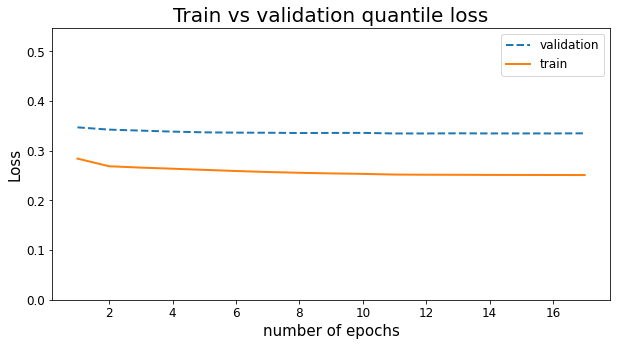

In [31]:
import matplotlib
import matplotlib.pyplot as plt
history_dict = history.history 
mean_q_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, figsize = (10, 5))
epochs = list(range(1, len(mean_q_loss) + 1))
ax.plot(epochs, validation_loss, linestyle = '--', linewidth = 2,
        label = "validation")
ax.plot(epochs, mean_q_loss, linewidth = 2, label = "train")
ax.set_xlabel('number of epochs', size = 15)
ax.set_ylabel('Loss', size = 15)
ax.set_ylim([0, np.max(np.append(mean_q_loss, validation_loss)) + 0.2])
ax.legend()
plt.title('Train vs validation quantile loss', size = 20)
plt.show()


In [33]:
fnl = create_model(3, 500, lr = 0.001)
fnl.load_weights("weights.h5")

In [35]:
val_preds = fnl.predict(val_data_dict, batch_size = 50_000) 
eval_preds = fnl.predict(eval_data_dict, batch_size = 50_000) 

print(val_preds.shape, eval_preds.shape)

(1199520, 9) (1199520, 9)


In [37]:
val_preds = val_preds.reshape((-1, 28, 9))
eval_preds = eval_preds.reshape((-1, 28, 9))

print(val_preds.shape, eval_preds.shape)

(42840, 28, 9) (42840, 28, 9)


In [38]:
val_preds

array([[[ 6.5971851e-01,  4.5856504e+00,  5.4252987e+00, ...,
          6.3318901e+00,  6.8770366e+00,  7.2561955e+00],
        [ 6.1293626e-01,  4.2139740e+00,  5.0541396e+00, ...,
          5.8559542e+00,  6.3246508e+00,  6.6308017e+00],
        [ 5.5784178e-01,  3.8603799e+00,  4.7880445e+00, ...,
          5.5752134e+00,  6.0172167e+00,  6.3047562e+00],
        ...,
        [ 7.5696695e-01,  5.3782015e+00,  6.1900277e+00, ...,
          7.1769519e+00,  7.7297812e+00,  8.4246054e+00],
        [ 9.0639365e-01,  6.8008132e+00,  7.6733155e+00, ...,
          8.8843660e+00,  9.6524611e+00,  1.0624310e+01],
        [ 9.5550549e-01,  7.2400413e+00,  8.1310463e+00, ...,
          9.5000219e+00,  1.0342160e+01,  1.1424388e+01]],

       [[ 5.0418937e-01,  3.5044439e+00,  4.2177358e+00, ...,
          5.7169623e+00,  6.9283571e+00,  7.9322834e+00],
        [ 4.7174394e-01,  3.2298298e+00,  3.9204116e+00, ...,
          5.3381624e+00,  6.5540948e+00,  7.5389714e+00],
        [ 4.8009714e-01, 

In [39]:
wts = evaluation_data[['wt', 'id']].drop_duplicates()
wts = wts.wt.values.reshape((-1, 1))
wts

array([[4.6554019e+02],
       [5.6371651e+01],
       [8.4910828e+01],
       ...,
       [2.2319588e-01],
       [3.9175257e-01],
       [1.4396871e+03]], dtype=float32)

In [40]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]

ids = validation_data['id'].unique()
d_cols =  ['F' + str(i) for i in range(1, 29)]

validation = []
evaluation = []

for i, qt in enumerate(QUANTILES):
  val_tmp = pd.DataFrame(val_preds[:, :, i] * wts, columns = d_cols)
  eval_tmp = pd.DataFrame(eval_preds[:, :, i] * wts, columns = d_cols)
  eval_tmp['id'] = ['_'.join([id, qt, 'evaluation']) for id in ids] 
  val_tmp['id'] = ['_'.join([id, qt, 'validation']) for id in ids] 
  validation.append(val_tmp)
  evaluation.append(eval_tmp)


validation_preds = pd.concat(validation).sort_values(by = 'id')
evaluation_preds = pd.concat(evaluation).sort_values(by = 'id')
submission = pd.concat([validation_preds, evaluation_preds])



In [41]:
validation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year_s,id,wt,state_id,store_id,cat_id,dept_id,item_id,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63
851,2,3,3,30,4,4,2,0,0,0,-0.635879,CA_1_FOODS,465.540192,0,0,0,7,3049,1914,2893.0,6.214286,5.327145,5.941485,5.960817,6.394722,5.294924,5.297072
852,3,3,3,30,4,4,2,0,0,0,-0.626388,CA_1_FOODS,465.540192,0,0,0,7,3049,1915,2518.0,5.408771,5.329293,5.580614,4.732137,5.773938,5.163894,5.168190
853,4,3,3,30,4,4,2,0,0,0,-0.616897,CA_1_FOODS,465.540192,0,0,0,7,3049,1916,2467.0,5.299220,4.586070,5.486100,5.073676,5.355069,5.230483,4.459336
854,5,3,3,30,4,4,2,0,0,0,-0.607406,CA_1_FOODS,465.540192,0,0,0,7,3049,1917,2446.0,5.254111,5.694460,5.758901,4.749321,5.393734,5.294924,4.674140
855,6,3,3,30,4,4,2,0,0,0,-0.597916,CA_1_FOODS,465.540192,0,0,0,7,3049,1918,3032.0,6.512864,6.727668,7.348453,5.904968,6.089700,6.089700,5.827639


In [48]:
submission.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,id
0,307.125488,285.346466,259.697754,288.880554,357.391418,428.988556,458.892456,371.581543,333.780823,309.294891,316.397980,387.353546,452.595795,358.705231,376.812317,314.997589,306.743652,316.628021,364.331116,434.402374,449.833801,346.546143,294.256409,288.891663,295.766418,352.398529,421.962677,444.826202,CA_1_FOODS_0.005_validation
0,2134.804688,1961.774292,1797.161987,1971.491943,2505.127930,3216.747803,3491.731689,2661.744385,2342.144775,2153.587891,2169.297607,2779.547119,3434.495850,2773.310791,2711.172852,2204.776367,2101.361816,2167.226318,2583.886719,3240.155762,3398.503906,2462.366699,2030.686523,1977.135742,2023.833130,2503.769043,3166.051758,3370.530273,CA_1_FOODS_0.025_validation
0,2525.694580,2352.905029,2229.027100,2349.352783,2822.561279,3591.881104,3924.009033,3013.477783,2678.541748,2558.157715,2540.927246,3136.960938,3834.997070,3305.158203,3034.507812,2618.412354,2454.275879,2504.969238,2921.378906,3626.264160,3789.824951,2824.292236,2461.109619,2399.235107,2443.343018,2881.706787,3572.236816,3785.328857,CA_1_FOODS_0.165_validation
0,2606.345459,2426.914551,2302.591309,2421.921387,2896.558350,3682.959961,4049.705078,3104.988037,2756.285645,2645.073242,2613.210693,3225.882812,3942.947021,3438.145752,3121.145508,2710.492920,2525.318115,2575.106445,3003.166992,3727.944824,3891.908203,2914.035156,2548.492676,2481.793701,2526.545410,2970.680664,3680.130127,3897.360840,CA_1_FOODS_0.250_validation
0,2759.049316,2561.383789,2433.604736,2554.657471,3049.593018,3871.406982,4339.297363,3312.590576,2937.099854,2826.292969,2765.780518,3430.297363,4185.889160,3680.010742,3329.465576,2904.329102,2672.902100,2726.546631,3186.236084,3921.516357,4117.970215,3104.252441,2713.892334,2636.664551,2688.261719,3156.079834,3884.786621,4131.556641,CA_1_FOODS_0.500_validation


In [47]:
submission.tail()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,id
42839,10796.185547,10451.115234,9904.946289,10313.694336,13238.050781,15398.114258,14398.750977,12446.802734,11214.876953,11699.023438,13211.453125,15849.351562,16546.818359,16849.443359,14688.167969,13033.849609,13384.339844,14053.256836,14225.465820,18067.585938,17250.513672,12447.360352,13046.164062,13101.930664,11680.033203,13298.565430,15391.659180,15002.351562,WI_X_0.500_evaluation
42839,11238.081055,10895.671875,10315.983398,10755.701172,13800.476562,16063.583984,14961.686523,13048.253906,11703.726562,12222.736328,13840.796875,16676.791016,17329.416016,17676.734375,15407.219727,13612.818359,14015.867188,14770.997070,14901.588867,18976.005859,18071.003906,12919.653320,13601.281250,13726.201172,12196.389648,13861.418945,16035.872070,15741.367188,WI_X_0.750_evaluation
42839,11430.170898,11084.362305,10495.616211,10945.144531,14126.202148,16526.246094,15345.207031,13352.599609,11938.089844,12546.962891,14189.512695,17227.525391,17897.951172,18247.021484,15901.878906,14066.140625,14382.762695,15230.513672,15349.529297,19612.119141,18642.173828,13238.113281,13939.970703,14138.144531,12496.837891,14249.483398,16508.013672,16264.044922,WI_X_0.835_evaluation
42839,12325.710938,12026.351562,11385.989258,11920.249023,15618.344727,18384.939453,16783.937500,14468.444336,13052.817383,13976.897461,15757.337891,19489.701172,20191.207031,20376.373047,17764.601562,15801.035156,15975.424805,17135.304688,17301.718750,22202.773438,20869.150391,14691.198242,15408.780273,15844.266602,13982.849609,16000.167969,18548.222656,18337.908203,WI_X_0.975_evaluation
42839,13545.746094,13305.033203,12509.032227,13182.897461,17620.900391,20760.431641,18710.599609,16086.150391,14596.454102,15947.922852,17959.136719,22518.791016,23215.751953,23218.769531,20363.351562,18274.390625,18211.949219,19720.224609,19929.234375,25608.529297,23864.507812,16791.855469,17531.968750,18119.601562,16061.426758,18401.505859,21265.017578,20993.062500,WI_X_0.995_evaluation


In [44]:
submission.to_csv('submission.csv', index=False)

In [45]:
!mkdir -p ~/.kaggle
!cp drive/My\ \Drive/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c m5-forecasting-uncertainty -f submission.csv -m "using similar scaling factor, 3 hidden layers, 500 units"

kaggle.json
100% 263M/263M [00:04<00:00, 62.4MB/s]
Successfully submitted to M5 Forecasting - Uncertainty